# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [42]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [5]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

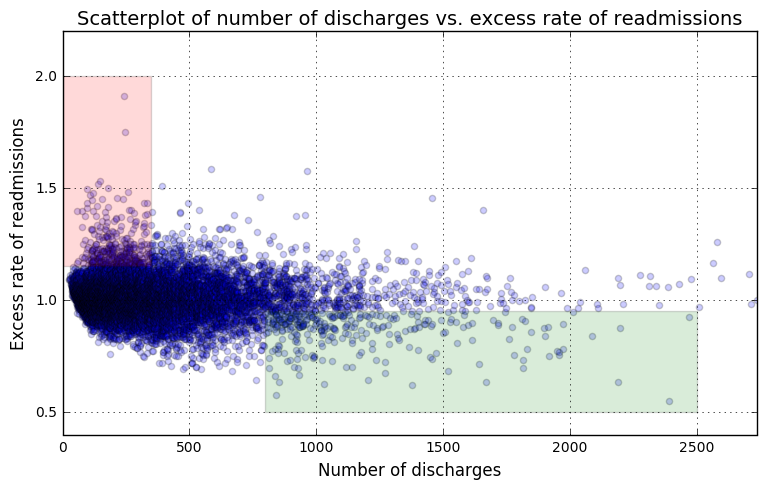

In [6]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

# Do you agree with the above analysis and recommendations? Why or why not?

Without executing my own analysis I can't say firmly whether I agree or disagree with the claims of the prior analysis, but I am highly suspicous of their conclusions.

The data tailing to the right is highly variable and rather sparse, and the average rate of readmission for discharges less than 100 is being affected by a number of outliers. 

Visually there looks to be a very weak trend between the two, and that's mostly because of the small group of points that have a high readmission rate with low discharges. These could all be affected by some other variable that doesn't have anything to do with discharges. 

Also, the author does not provide any significance measures; there is no p-value, or confidence interval. So all of this leads me to doubt the accuracy of the anaylsis and I would certainly not follow their recommendation without more rigourous analysis.

# My analysis

First I want to test if there is any correlation between the two variables.

In [36]:
# better way to get rid of the NaN's that the prior analysis was leaving out
df = clean_hospital_read_df[~clean_hospital_read_df['Excess Readmission Ratio'].isnull()]

A Pearson's correlation test will tell us if there is a relationship and in which direction that relationship is for our two variables.

In [52]:
df['Excess Readmission Ratio'].corr(df['Number of Discharges'])

-0.097397943510793533

Our Pearson's correlation coefficient is telling us there is a slightly negative corellation between the readmission ratio and the number of discharges. To tell us if this is significant we can do a permutation test to randomly reassign the pairs and re-calculate the coefficient value a large number of times. The proportion of values at or below our correllation coeefficient from that process is our p-value.



In [54]:
def pearson_bootstrap(frame, iterations=10000):
    results = []
    for _ in xrange(iterations):
        read_ratio = frame['Excess Readmission Ratio']
        num_dschrg = frame['Number of Discharges']
        read_resample = read_ratio.sample(n=len(read_ratio), replace=True)
        num_resample = num_dschrg.sample(n=len(num_dschrg), replace=True)
        
        results.append(read_resample.corr(num_resample))
    return results

In [56]:
results = pearson_bootstrap(df)

In [72]:
res_array = np.array(results)
conf_int = [np.percentile(res_array, 2.5), np.percentile(res_array, 97.5)]
conf_int

[-0.13711372945432435, -0.058649316786238748]

So we are 95% confident that the true correlation coefficient lies within that range, which is sufficient evidence to say there is a negative correllation between the readmission ratio and the number of discharges, though not a particularly strong one.

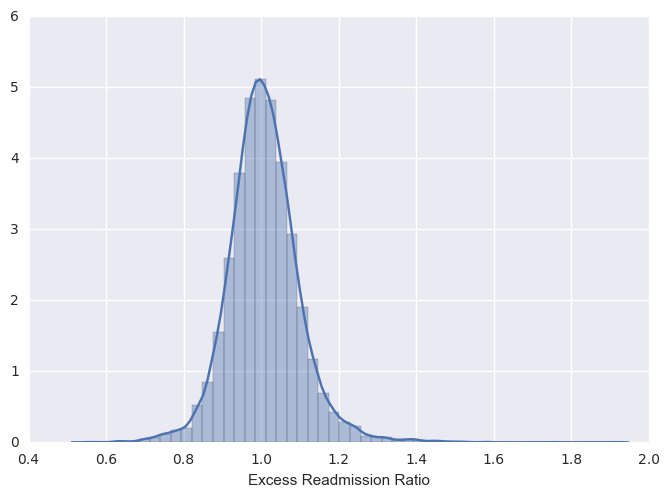

In [40]:
sns.distplot(df['Excess Readmission Ratio'])
None

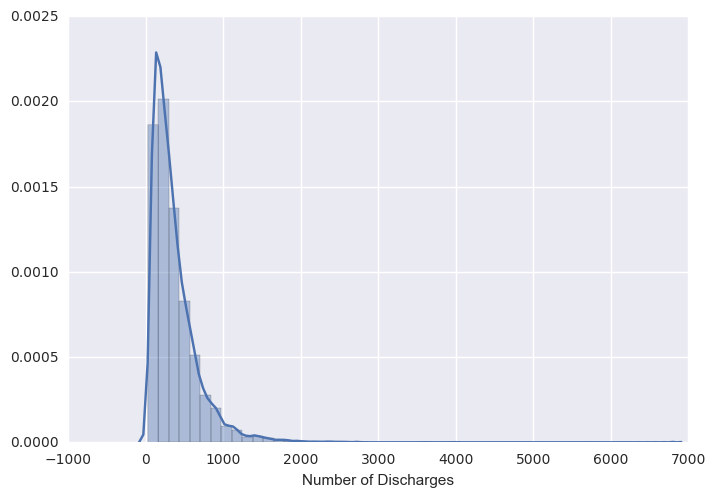

In [41]:
sns.distplot(df['Number of Discharges'])
None

From checking out the distribution of these variables we can see that the readmission ratio is normally distributed, but the number of discharges is heavily tailed to the right. 

This we can see in the original graphic by the dense region on the left of the chart and sparse on the right. 

This adds further suspicion to the result of the previous analysis, it does not look as though they took into consideration the much lower sample size of the 1000+ discharges category.

In [45]:
low_discharge = df[df['Number of Discharges'] < 100]
high_discharge = df[df['Number of Discharges'] > 1000]

In [47]:
low_discharge['Excess Readmission Ratio'].var()

0.0033615184329960682

In [48]:
high_discharge['Excess Readmission Ratio'].var()

0.014401764889811413

Because we do not know the standard deviation of the population, and the standard deviations of the samples are not equal, we will use a welch's t-test to see if there is a true difference in means betweeen these samples.


In [44]:
stats.ttest_ind(low_discharge['Excess Readmission Ratio'], 
                high_discharge['Excess Readmission Ratio'],
                equal_var=False)

Ttest_indResult(statistic=7.6017424185004856, pvalue=1.2752435451140344e-13)

With a p-value of $1.27*10^{-13}$ this is certainly statistically significant, even at the $\alpha = 0.01$ level.

# Statistical vs practical significance

The t-test performed shows that there is a significant difference between the hostpitals with fewer than 100 discharges and those with greater than 1000. Also the pearson's coefficient shows that there is a statistically significant negative correllation between the two variables.

However the effect size is 0.0442. So the average readmission ratio is 0.0442 higher in hospitals with a 1000 discharges or more compares to those with 100 or fewer. This is a 4.3% increase in the excess readmission ratio.

Practically, a 4.3% increase in the average excess readmission ratio is not something I would be overly concerned with. I would like some more context around how the excess readmission ratio is determined. I think that a larger hospital (one with more discharges) is more likely to be able to accurately predict their readmission rates, because they have a larger sample size of patients.

I also think that smaller hospitals can have their readmission ratios thrown way off by a couple of bad months, whereas a larger hospitals readmission ratio would get leveled out because of the larger number of patients that they process.

Based on all of this I would tell the client that I do not think that there is significant evidence to believe that making hospitals larger will lower the likelihood of readmission for patients. Though larger hospitals may report lower readmission rates, this is more likely to be because of statistical flukes than an actual causal link.

I would tell the client that there isn't strong enough evidence from this data to suggest that consolidation of hospitals will lead to fewer readmissions.

# Plotting

The above plot has advantages because it shows all of the points and has complete information about the two variables and where the points lie on that plane. However, the plot is a bit busy and to someone who doesn't regularly look at data visualiztions it could be confusing.

Also the highlighted regions would probably be better emphasized by coloring the points instead of a rectangular area.

The information that is pertinent to this study is how the average readmission ratio changes with the number of discharges. So I will plot a windowed average to illustrate this.

In [117]:
df['Average Excess Readmission Ratio'] = df.sort_values('Number of Discharges')['Excess Readmission Ratio'].rolling(300).mean()

/Users/zakscholl/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


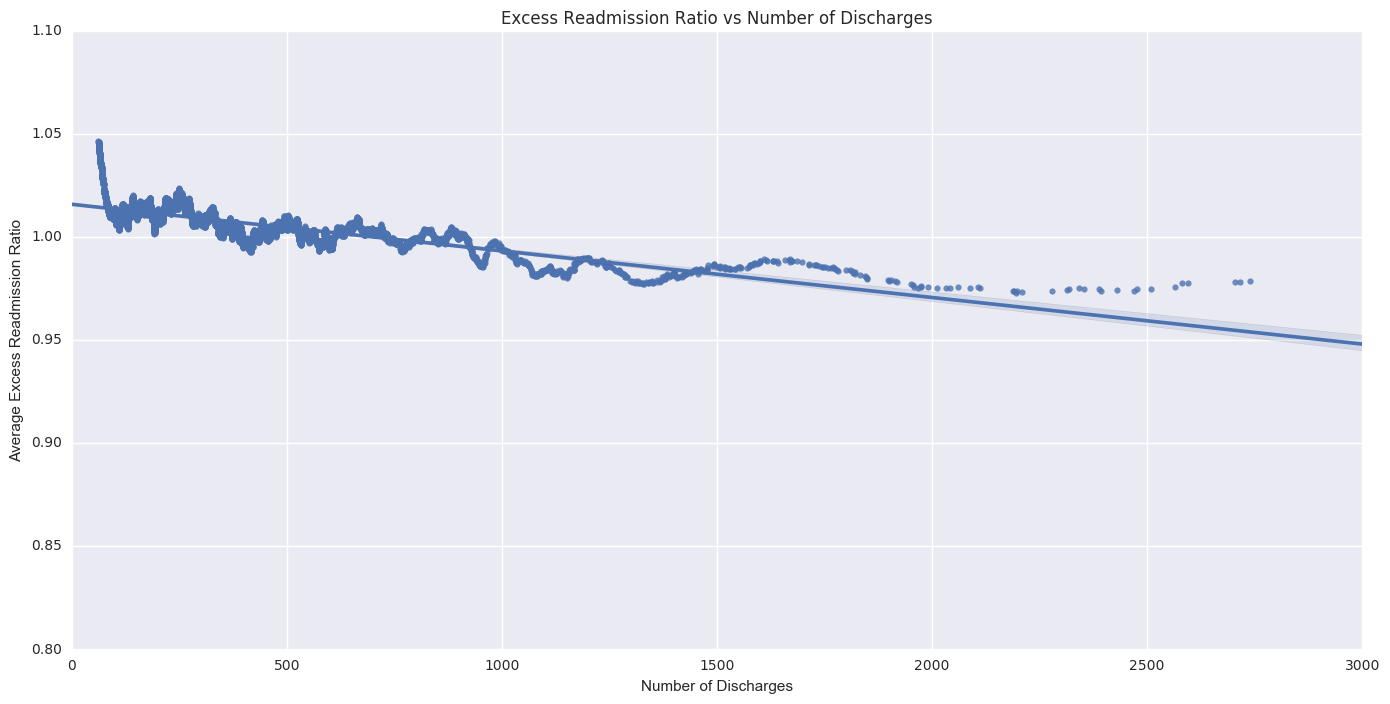

In [121]:
g = sns.lmplot(x="Number of Discharges", y="Average Excess Readmission Ratio", data=df, size=7, aspect=2)
g.set(xlim=[0,3000])
g.ax.set_title('Excess Readmission Ratio vs Number of Discharges')
None

This chart conveys the same information, with less clutter and it also conveniently has a fitted regression line to assist in visualizing the general trend.

What I think this plot also succeeds in, is drawing the attention to the large spike in excess readmission ratio among hostpitals with a very small number of discharges and shows that the excess readmission ratio tails off as the number of discharges increases.

The effect size is easily visible here as well, the viewer an see that the range of average readmission ratios goes fom ~1.05 to ~0.98. I think this clearly leads to a better picture of what is really going on with this data.
